## Line of Therapy based features

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Synthetic claim_level_data.csv')

In [ ]:
df['Pat_ID'].nunique()

306

In [ ]:
df['Product Name'].value_counts()

,count
Product Name,
Paclitaxel,338
NOVmatinib,335
Pemetrexed,245
Ticaprant,195
AZNertrib,145
BMSRizi,122


In [ ]:
df.head()

,Pat_ID,HCP_ID,Claim ID,HCPCS_ code,Transaction date,Diagnosis 1,Diagnosis 2,Diagnosis 3,Diagnosis 4,Product Name,Procedure Name,Product Category,Product Abbreviation,flag,YM,Gap,Lot number,start_date,end_date,Regimen
0,PATIENT_001,HCP_17,250748,J9999,04-21-2021,I10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,202104,0.0,1,04-21-2021,06-16-2021,NaN
1,PATIENT_001,HCP_17,268985,G9418,06-16-2021,I10,NaN,NaN,NaN,NaN,Biopsy,NaN,NaN,2,202106,56.0,1,04-21-2021,06-16-2021,NaN
2,PATIENT_001,HCP_17,277492,J9999,09-08-2021,I10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,202109,84.0,2,09-08-2021,11-22-2022,RIZ_TIC
3,PATIENT_001,HCP_17,286233,J9999,10-06-2021,I10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,202110,28.0,2,09-08-2021,11-22-2022,RIZ_TIC
4,PATIENT_001,HCP_17,302457,J9999,11-03-2021,I10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,202111,28.0,2,09-08-2021,11-22-2022,RIZ_TIC


In [ ]:
df[df['Gap']<0]

,Pat_ID,HCP_ID,Claim ID,HCPCS_ code,Transaction date,Diagnosis 1,Diagnosis 2,Diagnosis 3,Diagnosis 4,Product Name,Procedure Name,Product Category,Product Abbreviation,flag,YM,Gap,Lot number,start_date,end_date,Regimen


In [ ]:
df['Product Category'].value_counts()

,count
Product Category,
Market Basket,797
Chemotherapy,583


In [ ]:
df['Regimen'].value_counts()

,count
Regimen,
NOV_TIC,447
ERT_NOV,377
NOV,274
RIZ,136
ERT_TIC,119
RIZ_TIC,102
NOV_RIZ,88
ERT,87
TIC,77


# Outliers

- Never prescribed any product
- Claim count is two

In [ ]:
# Step 1: Count claims per patient
claim_count = df.groupby('Pat_ID')['Claim ID'].nunique()

# Step 2: Filter for patients with exactly 2 claims
patients_with_two_claims = claim_count[claim_count == 2].index

# Step 3: Identify patients never prescribed any products (Product Name is NaN)
patients_no_products = df[df['Product Name'].isna()]['Pat_ID'].unique()

# Step 4: Get the intersection of patients with two claims and no prescribed products
result_patients = [pat for pat in patients_with_two_claims if pat in patients_no_products]

# Display result count
result_count = len(result_patients)
result_count

30

In [ ]:
filtered_df = df[df['Pat_ID'].isin(result_patients) & df['Diagnosis 2'].str.startswith('C78')]
grouped_counts = filtered_df.groupby(['Pat_ID', 'Diagnosis 2']).size().reset_index(name='Count')
grouped_counts['Diagnosis 2'].value_counts()

,count
Diagnosis 2,
C78.8,7
C78.5,5
C78.4,5
C78.7,4
C78.3,2
C78,2


In [ ]:
filtered_df['Pat_ID'].nunique()

20

In [ ]:
df = df[~df['Pat_ID'].isin(result_patients)]
df.shape

(3163, 20)

In [ ]:
df['Pat_ID'].nunique()

276

In [ ]:
# Filter patients diagnosed with C34 in any of the four diagnosis columns
patients_with_c34 = df[
    df[['Diagnosis 1', 'Diagnosis 2', 'Diagnosis 3', 'Diagnosis 4']]
    .apply(lambda x: x.astype(str).str.startswith('C34')).any(axis=1)
]['Pat_ID'].unique()

len(patients_with_c34)

276

# Count of patients on a line

In [ ]:
# 1. Count of patients on a line
patients_on_line = df.groupby('Lot number')['Pat_ID'].nunique()
print("Count of patients on a line:")
print(patients_on_line)

Count of patients on a line:
Lot number
1    276
2    258
Name: Pat_ID, dtype: int64


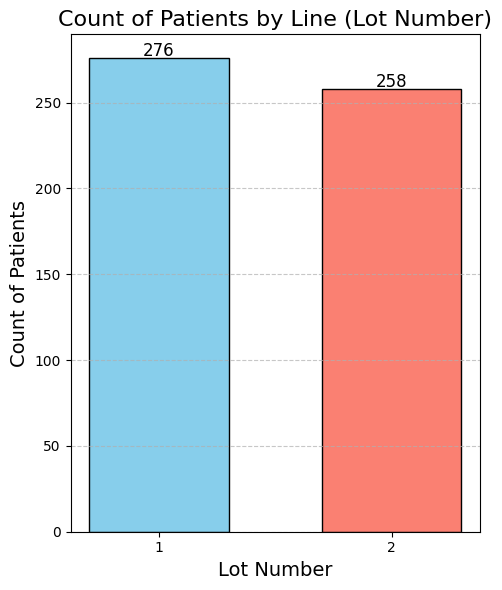

In [ ]:
import matplotlib.pyplot as plt

# Data for the plot
categories = ['1', '2']
counts = patients_on_line.values  # Replace with actual data

# Plotting the bar chart
plt.figure(figsize=(5, 6))  # Set the figure size
bars = plt.bar(categories, counts, color=['skyblue', 'salmon'], edgecolor='black', width=0.6)

# Add titles and labels
plt.title('Count of Patients by Line (Lot Number)', fontsize=16)
plt.xlabel('Lot Number', fontsize=14)
plt.ylabel('Count of Patients', fontsize=14)

# Add data labels on top of bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center text horizontally
        bar.get_height() + 1,              # Slightly above the bar
        f'{int(bar.get_height())}',        # Display the count
        ha='center',
        fontsize=12
    )

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure the layout fits well
plt.tight_layout()

# Show the plot
plt.show()

# Number of patients in L1 last year

In [ ]:
# Convert dates to datetime
df['Transaction date'] = pd.to_datetime(df['Transaction date'], format='%m-%d-%Y')
df['start_date'] = pd.to_datetime(df['start_date'], format='%m-%d-%Y')
df['end_date'] = pd.to_datetime(df['end_date'], format='%m-%d-%Y')

In [ ]:
# Extract the year from the 'Transaction date' column
df['Year'] = df['Transaction date'].dt.year

# Find the most recent year in the dataset
last_year = df['Year'].max()

print(f"The last year in the dataset is: {last_year}")

The last year in the dataset is: 2023


In [ ]:
# Filter for last year
last_year_start = pd.Timestamp('2022-01-01')
last_year_end = pd.Timestamp('2022-12-31')

In [ ]:
# 2. Number of patients in L1 last year
patients_in_L1_last_year = df[(df['Lot number'] == 1) &
                              (df['Transaction date'].between(last_year_start, last_year_end))]['Pat_ID'].nunique()
print("\nNumber of patients in L1 last year:", patients_in_L1_last_year)


Number of patients in L1 last year: 176


# Number of patients in L1 last year

In [ ]:
# 2. Number of patients in L1 last year
patients_in_L2_last_year = df[(df['Lot number'] == 2) &
                              (df['Transaction date'].between(last_year_start, last_year_end))]['Pat_ID'].nunique()
print("\nNumber of patients in L2 last year:", patients_in_L2_last_year)


Number of patients in L2 last year: 258


# Number of patients in L1 last year for a specific product

In [ ]:
# 3. Number of patients in L1 last year for a specific product
product_name = 'Ticaprant'  # Change this to the product name of interest
patients_in_L1_last_year_for_product = df[(df['Lot number'] == 1) &
                                          (df['Transaction date'].between(last_year_start, last_year_end)) &
                                          (df['Product Name'] == product_name)]['Pat_ID'].nunique()
print(f"\nNumber of patients in L1 last year for {product_name}:", patients_in_L1_last_year_for_product)


Number of patients in L1 last year for Ticaprant: 18


# Number of patients in L2 last year for a specific product

In [ ]:
# 3. Number of patients in L2 last year for a specific product
product_name = 'Ticaprant'  # Change this to the product name of interest
patients_in_L2_last_year_for_product = df[(df['Lot number'] == 2) &
                                          (df['Transaction date'].between(last_year_start, last_year_end)) &
                                          (df['Product Name'] == product_name)]['Pat_ID'].nunique()
print(f"\nNumber of patients in L2 last year for {product_name}:", patients_in_L2_last_year_for_product)


Number of patients in L2 last year for Ticaprant: 51


# Patients in the 1st line for our product in Chemo (last year)

In [ ]:
df['Product Name'].value_counts()

,count
Product Name,
Paclitaxel,338
NOVmatinib,335
Pemetrexed,245
Ticaprant,195
AZNertrib,145
BMSRizi,122


In [ ]:
pat_df = pd.read_csv('Synthetic Patient_cohort_table_final.csv')

In [ ]:
chemo_patients = pat_df[pat_df['Chemo Patients'] == 1]['Pat_ID'].unique()

In [ ]:
# 5. Patients in the 1st line for our product in Chemo (last year)
chemo_patients_L1 = df[(df['Lot number'] == 1) &
                       (df['Pat_ID'].isin(chemo_patients)) &
                       (df['Product Name'] == 'Ticaprant') &
                       (df['Transaction date'].between(last_year_start, last_year_end))]['Pat_ID'].nunique()
print("\nPatients in the 1st line for our product in Chemo (last year):")
print(chemo_patients_L1)


Patients in the 1st line for our product in Chemo (last year):
14


# 5. Patients in the 2nd line for our product in Chemo (last year)

In [ ]:
# 5. Patients in the 2nd line for our product in Chemo (last year)
chemo_patients_L2 = df[(df['Lot number'] == 2) &
                       (df['Pat_ID'].isin(chemo_patients)) &
                       (df['Product Name'] == 'Ticaprant') &
                       (df['Transaction date'].between(last_year_start, last_year_end))]['Pat_ID'].nunique()
print("\nPatients in the 1st line for our product in Chemo (last year):")
print(chemo_patients_L2)


Patients in the 1st line for our product in Chemo (last year):
20


# Patients in the 1st line for our product in EGFR (last year)

In [ ]:
pat_df.head()

,Pat_ID,NSCLC Patients,mNSCLC Patients,mNSCLC_egfr Patients,mNSCLC_egfr_MKT Patients,mNSCLC_egfr_Ticaprant Patients,Chemo Patients,first_NSCLC_diagnosis_date,first_mNSCLC_diagnosis_date,first_egfr_date,last_egfr_date
0,PATIENT_001,1,1,1,1,1,0,20211229,20211229.0,20211229.0,20221122.0
1,PATIENT_002,1,1,1,1,0,0,20220102,20220102.0,20220102.0,20230112.0
2,PATIENT_003,1,1,1,1,1,0,20220331,20220331.0,20220331.0,20221228.0
3,PATIENT_004,1,1,1,1,0,0,20220310,20220310.0,20220310.0,20221125.0
4,PATIENT_005,1,1,1,1,0,0,20211224,20211224.0,20211224.0,20221219.0


In [ ]:
egfr_patients = pat_df[pat_df['mNSCLC_egfr Patients'] == 1]['Pat_ID'].unique()

In [ ]:
# 6. Patients in the 1st line for our product in EGFR (last year)
egfr_patients_L1 = df[(df['Lot number'] == 1) &
                      (df['Pat_ID'].isin(egfr_patients)) &
                      (df['Product Name'] == 'Ticaprant')&
                      (df['Transaction date'].between(last_year_start, last_year_end))]['Pat_ID'].nunique()
print("\nPatients in the 1st line for our product in EGFR (last year):")
print(egfr_patients_L1)


Patients in the 1st line for our product in EGFR (last year):
6


# Patients in the 2nd line for our product in EGFR (last year)

In [ ]:
# 6. Patients in the 2nd line for our product in EGFR (last year)
egfr_patients_L2 = df[(df['Lot number'] == 2) &
                      (df['Pat_ID'].isin(egfr_patients)) &
                      (df['Product Name'] == 'Ticaprant')&
                      (df['Transaction date'].between(last_year_start, last_year_end))]['Pat_ID'].nunique()
print("\nPatients in the 1st line for our product in EGFR (last year):")
print(egfr_patients_L2)


Patients in the 1st line for our product in EGFR (last year):
30


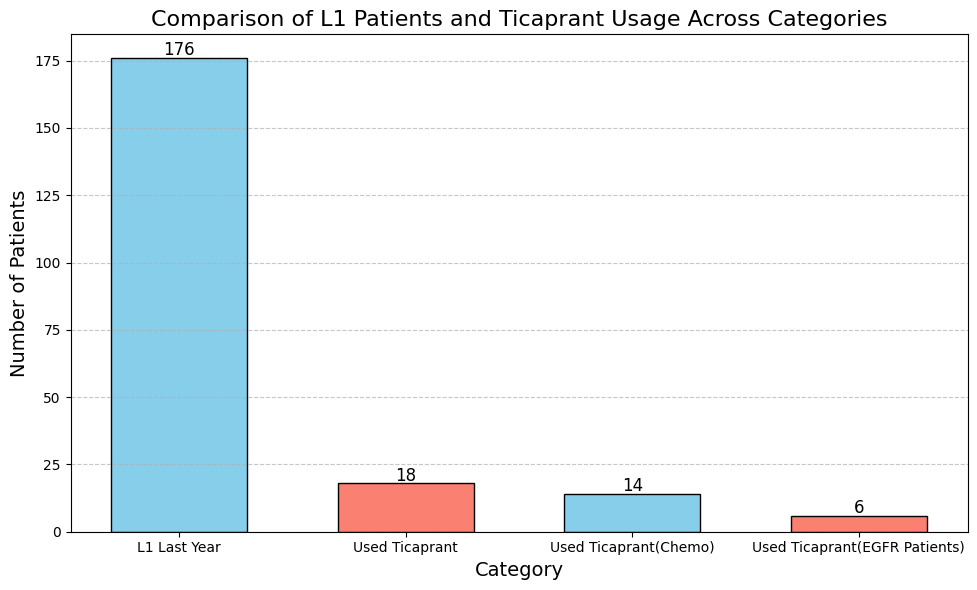

In [ ]:
import matplotlib.pyplot as plt

# Data for the plot
categories = ['L1 Last Year', 'Used Ticaprant','Used Ticaprant(Chemo)','Used Ticaprant(EGFR Patients)']
counts = [patients_in_L1_last_year, patients_in_L1_last_year_for_product,chemo_patients_L1,egfr_patients_L1]  # Replace with actual data

# Plotting the bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(categories, counts, color=['skyblue', 'salmon'], edgecolor='black', width=0.6)

# Add titles and labels
plt.title('Comparison of L1 Patients and Ticaprant Usage Across Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)

# Add data labels on top of bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center text horizontally
        bar.get_height() + 1,              # Slightly above the bar
        f'{int(bar.get_height())}',        # Display the count
        ha='center',
        fontsize=12
    )

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure the layout fits well
plt.tight_layout()

# Show the plot
plt.show()

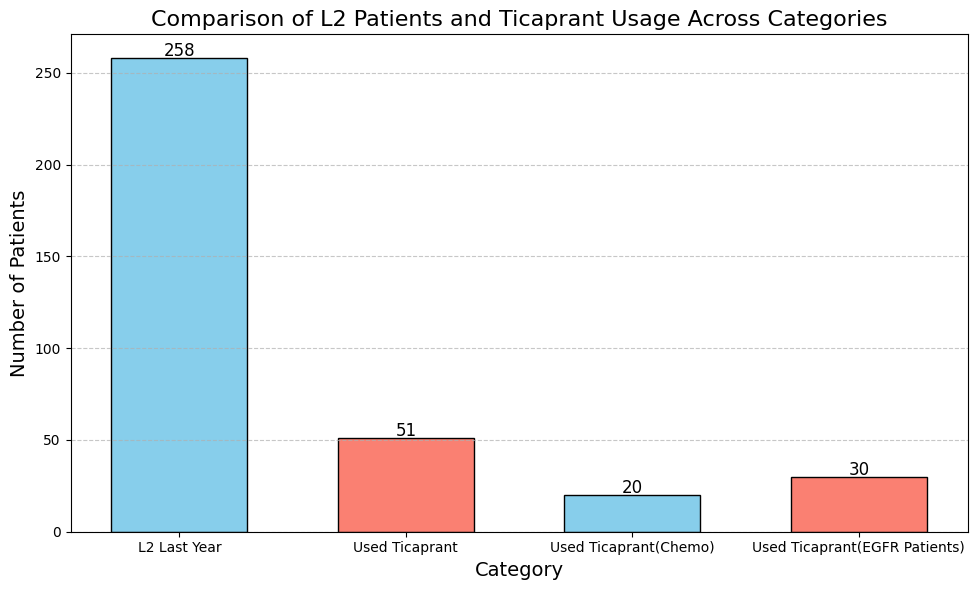

In [ ]:
import matplotlib.pyplot as plt

# Data for the plot
categories = ['L2 Last Year', 'Used Ticaprant','Used Ticaprant(Chemo)','Used Ticaprant(EGFR Patients)']
counts = [patients_in_L2_last_year, patients_in_L2_last_year_for_product,chemo_patients_L2,egfr_patients_L2]  # Replace with actual data

# Plotting the bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(categories, counts, color=['skyblue', 'salmon'], edgecolor='black', width=0.6)

# Add titles and labels
plt.title('Comparison of L2 Patients and Ticaprant Usage Across Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)

# Add data labels on top of bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center text horizontally
        bar.get_height() + 1,              # Slightly above the bar
        f'{int(bar.get_height())}',        # Display the count
        ha='center',
        fontsize=12
    )

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure the layout fits well
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df['HCP_ID'].nunique()

84

In [ ]:
df['Pat_ID'].nunique()

276

# Average days spent by a HCP in a line 1

In [ ]:
# Ensure Transaction_Date is in datetime format
df['Transaction date'] = pd.to_datetime(df['Transaction date'])

# Filter for Line of Therapy One
therapy_one_data = df[df['Lot number'] == 1]

# Group by HCP_ID and Patient_ID to calculate min and max transaction dates
hcp_patient_days = (
    therapy_one_data.groupby(['HCP_ID', 'Pat_ID'])['Transaction date']
    .agg(['min', 'max'])
    .reset_index()
)

# Calculate the duration in days for each HCP-PATIENT pair
hcp_patient_days['Duration'] = (hcp_patient_days['max'] - hcp_patient_days['min']).dt.days

In [ ]:
# Group by HCP_ID to calculate the total and average duration for each HCP
hcp_avg_days = hcp_patient_days.groupby('HCP_ID')['Duration'].mean().reset_index()

# Calculate the overall average days per HCP
average_days_per_hcp = hcp_avg_days['Duration'].mean()

print(f"The average days per HCP for Line of Therapy One is: {average_days_per_hcp:.2f}")

The average days per HCP for Line of Therapy One is: 43.85


In [ ]:
hcp_data_filtered = hcp_avg_days

# Create a distinction between HCPs: Group HCP_1 to HCP_34 and the rest
hcp_data_filtered['Group'] = hcp_data_filtered['HCP_ID'].apply(
    lambda x: 'HCP_1-34' if int(x.split('_')[1]) < 34 else 'HCP_35+'
)

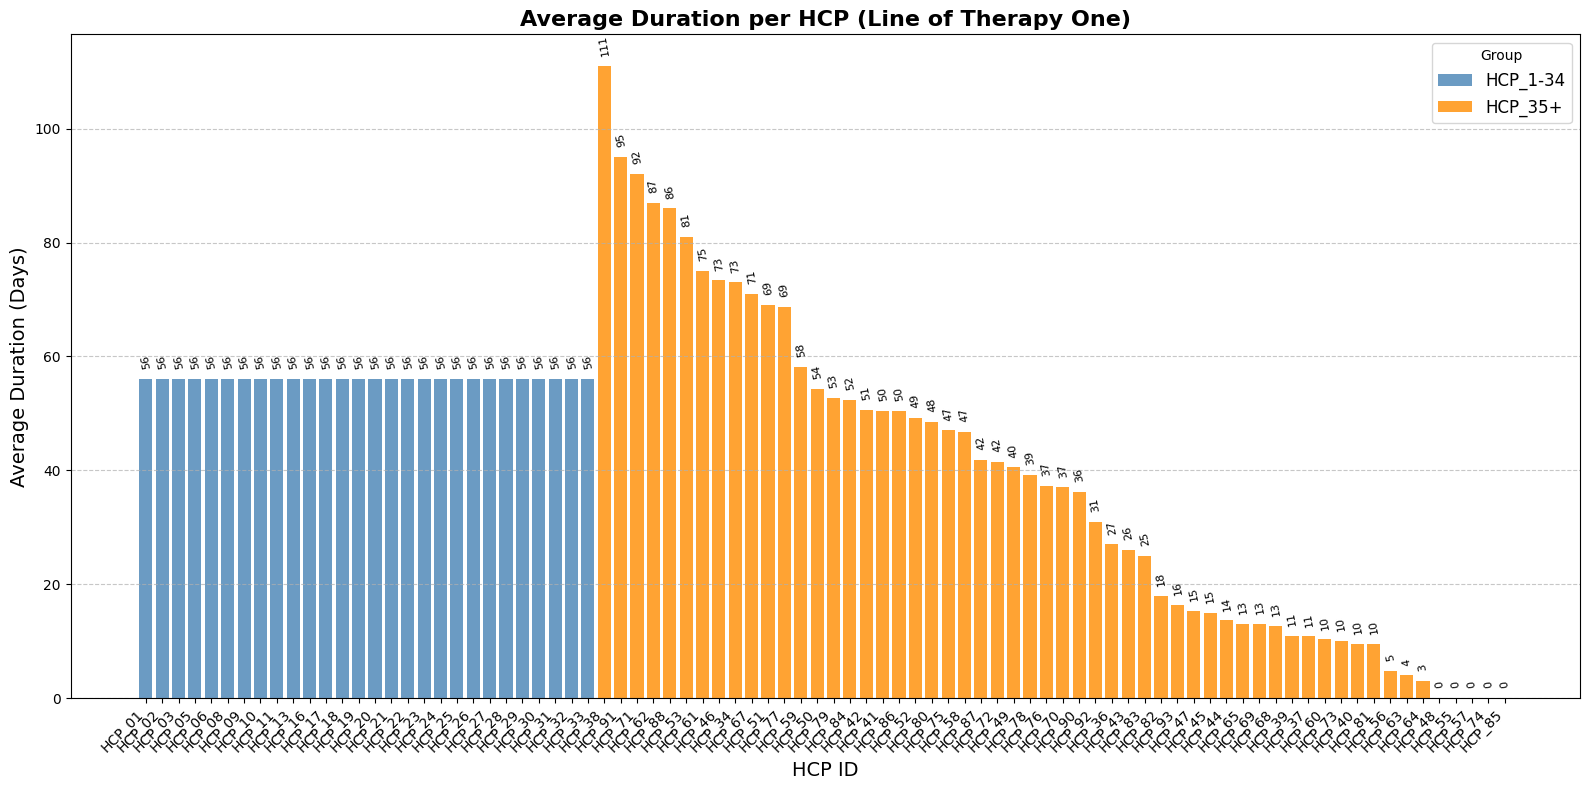

In [ ]:
# Sort data by Group and Duration for better readability => monitored for 2 cycles of 28 days
hcp_data_filtered = hcp_data_filtered.sort_values(by=['Group', 'Duration'], ascending=[True, False])

# Plotting with enhanced readability
plt.figure(figsize=(16, 8))
colors = {'HCP_1-34': 'steelblue', 'HCP_35+': 'darkorange'}

for group in hcp_data_filtered['Group'].unique():
    subset = hcp_data_filtered[hcp_data_filtered['Group'] == group]
    plt.bar(subset['HCP_ID'], subset['Duration'], label=group, color=colors[group], alpha=0.8)

# Adding annotations for clarity
for idx, row in hcp_data_filtered.iterrows():
    plt.text(row['HCP_ID'], row['Duration']+2, f"{row['Duration']:.0f}", ha='center', fontsize=8, rotation=100)

# Enhanced chart labels and styles
plt.title('Average Duration per HCP (Line of Therapy One)', fontsize=16, weight='bold')
plt.xlabel('HCP ID', fontsize=14)
plt.ylabel('Average Duration (Days)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Group', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
hcp_patient_days['Pat_ID'].nunique()

276

In [ ]:
# Patients who spent zero days in L1
hcp_patient_days[hcp_patient_days['Duration']==0]

,HCP_ID,Pat_ID,min,max,Duration
101,HCP_34,PATIENT_246,2022-01-21,2022-01-21,0
104,HCP_37,PATIENT_281,2022-06-18,2022-06-18,0
105,HCP_37,PATIENT_358,2022-01-16,2022-01-16,0
108,HCP_37,PATIENT_403,2022-05-23,2022-05-23,0
111,HCP_39,PATIENT_423,2022-01-19,2022-01-19,0
...,...,...,...,...,...
262,HCP_87,PATIENT_302,2022-04-17,2022-04-17,0
266,HCP_90,PATIENT_345,2022-01-19,2022-01-19,0
269,HCP_91,PATIENT_332,2022-06-11,2022-06-11,0
272,HCP_92,PATIENT_391,2022-01-19,2022-01-19,0


In [ ]:
# Count of patients(unique) who spent zero days in L1
hcp_patient_days[hcp_patient_days['Duration']==0]['Pat_ID'].nunique()

72

In [ ]:
# Count of HCPs(unique) who spent zero days in L1
hcp_patient_days[hcp_patient_days['Duration']==0]['HCP_ID'].nunique()

46

# Patients transitioned into L2 after initial visit

In [ ]:
# Patient transitioned into L2 after initial visit
df[df['Pat_ID']=='PATIENT_281'][['Pat_ID','HCP_ID','Transaction date','Lot number','Gap','Product Name']]

,Pat_ID,HCP_ID,Transaction date,Lot number,Gap,Product Name
2672,PATIENT_281,HCP_37,2022-06-18,1,0.0,Paclitaxel
2673,PATIENT_281,HCP_37,2022-08-26,2,69.0,Paclitaxel


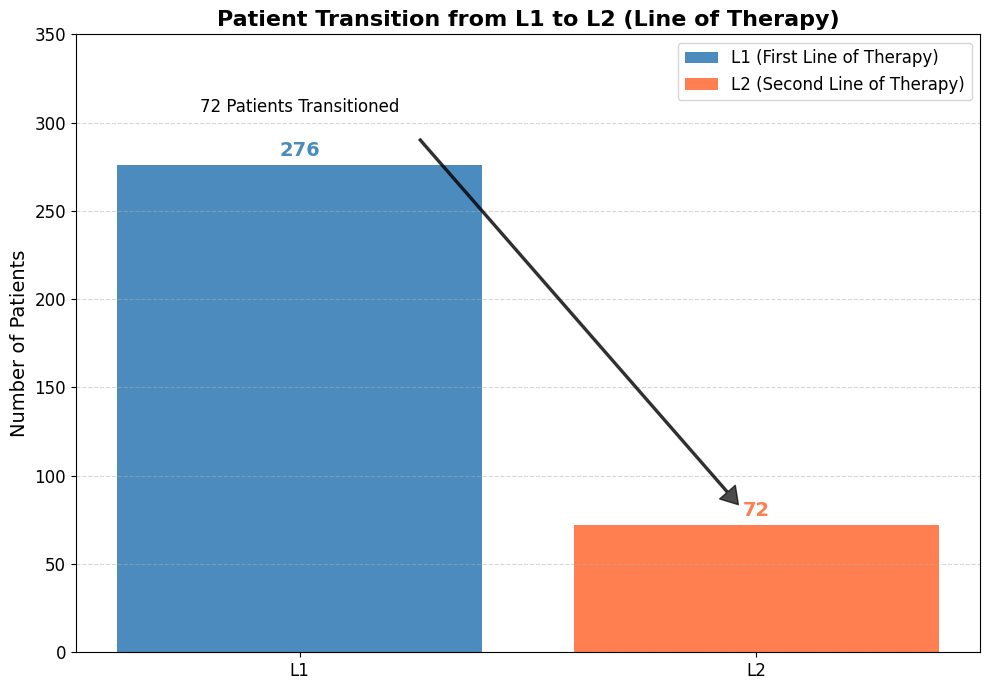

In [ ]:
# Data for the plot
l1_count = 276  # Number of patients in L1
l2_count = 72

plt.figure(figsize=(10, 7))
plt.bar(['L1'], [l1_count], color='#4B8BBE', label='L1 (First Line of Therapy)')  # Blue shade for L1
plt.bar(['L2'], [l2_count], color='#FF7F50', label='L2 (Second Line of Therapy)')  # Coral shade for L2

# Drawing the transition arrow with better styling
plt.annotate(
    '72 Patients Transitioned',  # Text to display
    xy=('L2', l2_count),  # Arrow tip (L2 bar)
    xytext=('L1', l1_count + 30),  # Arrow start (L1 bar, slightly above for visibility)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=15, alpha=0.7),
    fontsize=12,
    ha='center'
)

# Adding numerical labels directly on bars
plt.text(0, l1_count + 5, f'{l1_count}', ha='center', fontsize=14, fontweight='bold', color='#4B8BBE')
plt.text(1, l2_count + 5, f'{l2_count}', ha='center', fontsize=14, fontweight='bold', color='#FF7F50')

# Labels and title
plt.ylabel('Number of Patients', fontsize=14)
plt.title('Patient Transition from L1 to L2 (Line of Therapy)', fontsize=16, fontweight='bold')
plt.ylim(0, 350)  # Set y-limit for better visualization
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
patients = hcp_patient_days[hcp_patient_days['Duration']==0]['Pat_ID'].unique()

In [ ]:
df[df['Pat_ID'].isin(patients)]['Gap'].mean()

50.17629179331307

In [ ]:
df[df['Pat_ID'].isin(patients)]['Regimen'].value_counts()

,count
Regimen,
NOV,43
TIC,42
RIZ,40
ERT,31
ERT_RIZ,10
NOV_TIC,8
RIZ_TIC,6
ERT_TIC,5


In [ ]:
# Verifying if all the patient transitioned into L2 after initial visit

# Step 1: Filter patients of interest
filtered_df = df[df['Pat_ID'].isin(patients)].copy()

# Step 2: Identify the first LOT 1 occurrence for each patient
filtered_df.loc[:, 'first_lot1_date'] = (
    filtered_df.loc[filtered_df['Lot number'] == 1]
    .groupby('Pat_ID')['Transaction date']
    .transform('min')
)

# Step 3: Fill NaT with the first available transaction date per patient
filtered_df['first_lot1_date'] = filtered_df.groupby('Pat_ID')['first_lot1_date'].transform(lambda x: x.fillna(x.min()))

# Step 4: Check if a transition to LOT 2 happens after the first LOT 1 date
filtered_df.loc[:, 'transition_to_lot2'] = (
    (filtered_df['Lot number'] == 2) &
    (filtered_df['Transaction date'] > filtered_df['first_lot1_date'])
)

# Step 5: Filter patients who transitioned to LOT 2 after the first LOT 1
transitioned_patients = filtered_df[filtered_df['transition_to_lot2']]

In [ ]:
transitioned_patients['transition_to_lot2'].value_counts()

,count
transition_to_lot2,
True,257


In [ ]:
df[df['Pat_ID'].isin(patients)]['Gap'].mean()

50.17629179331307

In [ ]:
df[df['Pat_ID'].isin(patients)]['Diagnosis 1'].value_counts()

,count
Diagnosis 1,
C34,61
C34.1,44
C34.8,43
C34.2,42
I10,39
C34.11,38
C34.3,34
C34.12,28


# mNSCLC Patients

In [ ]:
filtered_df = df[df['Pat_ID'].isin(patients) & df['Diagnosis 2'].str.startswith('C78')]
grouped_counts = filtered_df.groupby(['Pat_ID', 'Diagnosis 2']).size().reset_index(name='Count')
grouped_counts['Diagnosis 2'].value_counts()

,count
Diagnosis 2,
C78.8,27
C78.4,27
C78.7,25
C78,21
C78.3,19
C78.5,14


In [ ]:
grouped_counts['Pat_ID'].nunique()

66

In [ ]:
product_usage = filtered_df.groupby(['Pat_ID', 'Product Name']).size().reset_index(name='Count')
product_usage

,Pat_ID,Product Name,Count
0,PATIENT_137,BMSRizi,1
1,PATIENT_144,AZNertrib,1
2,PATIENT_150,AZNertrib,1
3,PATIENT_150,Ticaprant,1
4,PATIENT_156,AZNertrib,2
5,PATIENT_174,BMSRizi,1
6,PATIENT_174,Paclitaxel,2
7,PATIENT_174,Pemetrexed,1
8,PATIENT_184,NOVmatinib,2
9,PATIENT_189,NOVmatinib,2


In [ ]:
product_usage['Product Name'].value_counts()

,count
Product Name,
Ticaprant,11
BMSRizi,10
Paclitaxel,9
NOVmatinib,9
AZNertrib,5
Pemetrexed,5


In [ ]:
non_mnsclc = df[df['Pat_ID'].isin(patients)]
non_mnsclc = non_mnsclc[~non_mnsclc['Pat_ID'].isin(grouped_counts['Pat_ID'].unique())]

In [ ]:
non_mnsclc['Pat_ID'].nunique()

6

In [ ]:
non_mnsclc

,Pat_ID,HCP_ID,Claim ID,HCPCS_ code,Transaction date,Diagnosis 1,Diagnosis 2,Diagnosis 3,Diagnosis 4,Product Name,...,Product Category,Product Abbreviation,flag,YM,Gap,Lot number,start_date,end_date,Regimen,Year
2295,PATIENT_170,HCP_81,391,70460,2022-03-05,C34.1,NaN,NaN,NaN,NaN,...,NaN,NaN,2,202203,0.0,1,2022-03-05,2022-03-05,NaN,2022
2296,PATIENT_170,HCP_81,389,J2002,2022-06-01,C34.2,NaN,NaN,NaN,Paclitaxel,...,Chemotherapy,NaN,2,202206,88.0,2,2022-06-01,2022-08-07,NaN,2022
2297,PATIENT_170,HCP_81,385,70460,2022-06-13,C34,NaN,S0240AA,NaN,NaN,...,NaN,NaN,2,202206,12.0,2,2022-06-01,2022-08-07,NaN,2022
2298,PATIENT_170,HCP_81,387,J2002,2022-08-07,C34.1,75489,S92209B,NaN,Paclitaxel,...,Chemotherapy,NaN,2,202208,55.0,2,2022-06-01,2022-08-07,NaN,2022
2487,PATIENT_233,HCP_60,869,J2001,2022-01-16,C34,Z72,T46903,NaN,Pemetrexed,...,Chemotherapy,NaN,2,202201,0.0,1,2022-01-16,2022-01-16,NaN,2022
2488,PATIENT_233,HCP_60,872,J2001,2022-10-12,C34,I10,NaN,NaN,Pemetrexed,...,Chemotherapy,NaN,2,202210,269.0,2,2022-10-12,2022-10-12,NaN,2022
2757,PATIENT_302,HCP_87,1436,70450,2022-04-17,C34,NaN,NaN,NaN,NaN,...,NaN,NaN,3,202204,0.0,1,2022-04-17,2022-04-17,NaN,2022
2758,PATIENT_302,HCP_87,1441,70450,2022-07-27,C34.8,NaN,NaN,NaN,NaN,...,NaN,NaN,3,202207,101.0,2,2022-07-27,2022-11-15,NaN,2022
2759,PATIENT_302,HCP_87,1438,70450,2022-11-15,C34,75489,C78.4,NaN,NaN,...,NaN,NaN,3,202211,111.0,2,2022-07-27,2022-11-15,NaN,2022
2931,PATIENT_351,HCP_85,1836,J9999,2022-02-18,I10,Z57.31,Q7951,NaN,NaN,...,NaN,NaN,2,202202,0.0,1,2022-02-18,2022-02-18,NaN,2022


- All the patients have transitioned from L1 to L2 after initial visit

# Missing Data - Replace the patients with duration of days being zero with the gap obtained by L2

In [ ]:
filtered_df = df[df['Pat_ID'].isin(patients)]

# Step 1: Filter for patients in L2 (first occurrence per patient)
first_l2_gaps = (
    filtered_df[filtered_df['Lot number'] == 2]
    .groupby('Pat_ID')
    .first()['Gap']
    .reset_index()
)

# Step 2: Create a mapping of Pat_ID to first non-zero gap
gap_mapping = first_l2_gaps.set_index('Pat_ID')['Gap']

# Step 3: Fill zero durations in hcp_patient_days
hcp_patient_days['Duration'] = hcp_patient_days.apply(
    lambda x: gap_mapping[x['Pat_ID']] if x['Duration'] == 0 and x['Pat_ID'] in gap_mapping else x['Duration'],
    axis=1
)


In [ ]:
# Group by HCP_ID to calculate the total and average duration for each HCP
hcp_avg_days = hcp_patient_days.groupby('HCP_ID')['Duration'].mean().reset_index()

# Calculate the overall average days per HCP
average_days_per_hcp = hcp_avg_days['Duration'].mean()

print(f"The average days per HCP for Line of Therapy One is: {average_days_per_hcp:.2f}")

The average days per HCP for Line of Therapy One is: 75.89


# Analysing patient journey of HCPs treated by HCP_01 to HCP_34

In [ ]:
hcp_range = [f'HCP_{str(i).zfill(2)}' for i in range(1, 33)]
therapy_one_data_filtered = therapy_one_data[therapy_one_data['HCP_ID'].isin(hcp_range)]
therapy_one_data_filtered['Product Name'].value_counts() #No product is prescribed

,count
Product Name,


In [ ]:
therapy_one_data_filtered['Product Category'].value_counts() #No chemo

,count
Product Category,


- Patients were not prescribed any market basket or chemotherapy product by HCPs 1 to 33 in L1.

# Average Duration spent by HCP in L1

In [ ]:
hcp_data_filtered = hcp_avg_days

# Create a distinction between HCPs: Group HCP_1 to HCP_34 and the rest
hcp_data_filtered['Group'] = hcp_data_filtered['HCP_ID'].apply(
    lambda x: 'HCP_1-34' if int(x.split('_')[1]) < 34 else 'HCP_35+'
)

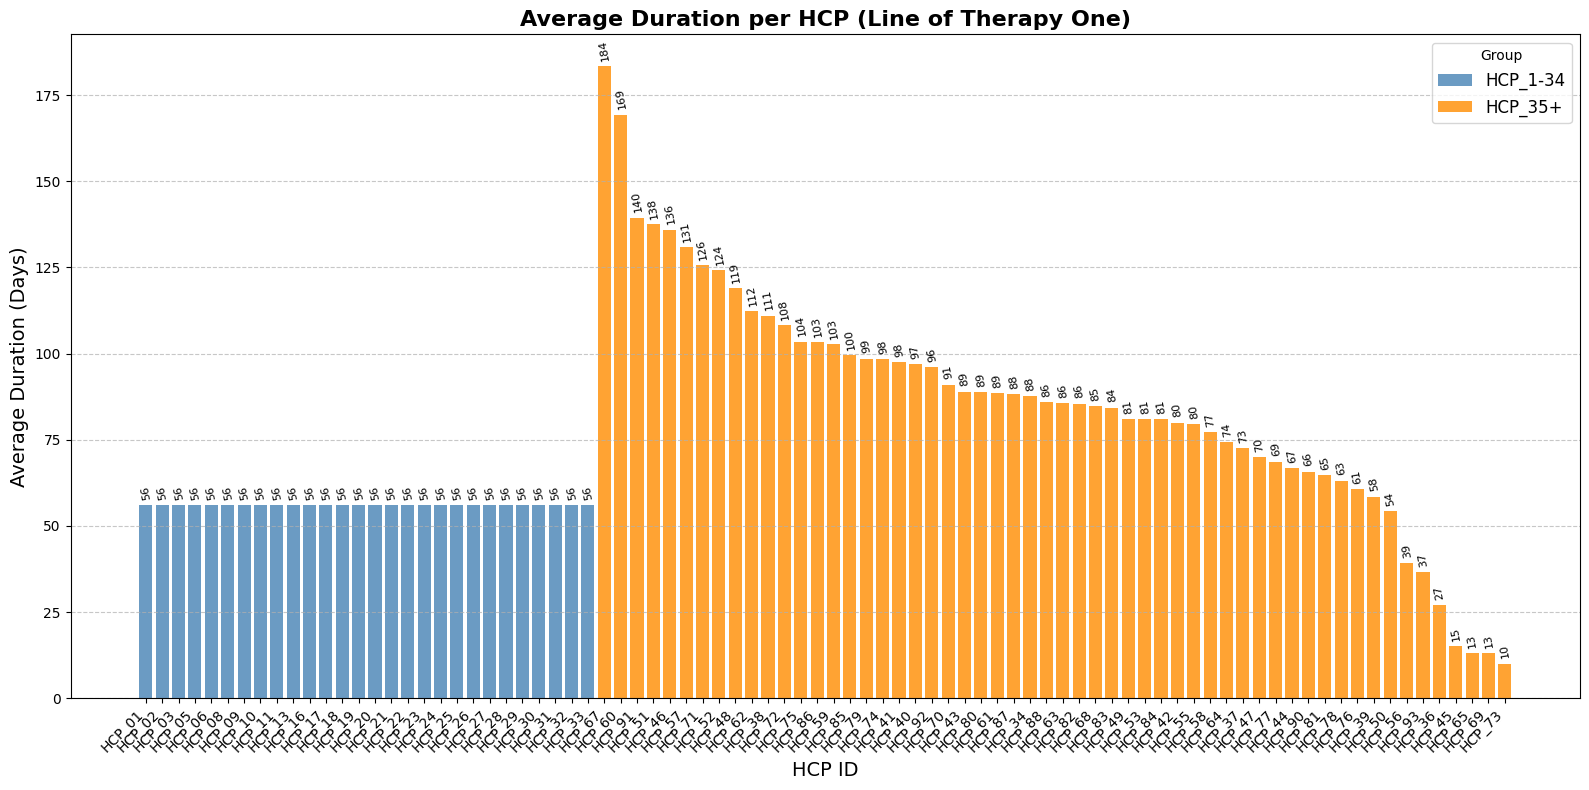

In [ ]:
# Sort data by Group and Duration for better readability => monitored for 2 cycles of 28 days
hcp_data_filtered = hcp_data_filtered.sort_values(by=['Group', 'Duration'], ascending=[True, False])

# Plotting with enhanced readability
plt.figure(figsize=(16, 8))
colors = {'HCP_1-34': 'steelblue', 'HCP_35+': 'darkorange'}

for group in hcp_data_filtered['Group'].unique():
    subset = hcp_data_filtered[hcp_data_filtered['Group'] == group]
    plt.bar(subset['HCP_ID'], subset['Duration'], label=group, color=colors[group], alpha=0.8)

# Adding annotations for clarity
for idx, row in hcp_data_filtered.iterrows():
    plt.text(row['HCP_ID'], row['Duration']+2, f"{row['Duration']:.0f}", ha='center', fontsize=8, rotation=100)

# Enhanced chart labels and styles
plt.title('Average Duration per HCP (Line of Therapy One)', fontsize=16, weight='bold')
plt.xlabel('HCP ID', fontsize=14)
plt.ylabel('Average Duration (Days)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Group', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

- No. of patients with duration in L1 being zero - 72
- Pattern Observed - Duration is zero since every patient transitions to L2 after initial visit

# Line of therapy two

In [ ]:
# Ensure Transaction_Date is in datetime format
df['Transaction date'] = pd.to_datetime(df['Transaction date'])

# Filter for Line of Therapy One
therapy_two_data = df[df['Lot number'] == 2]

# Group by HCP_ID and Patient_ID to calculate min and max transaction dates
hcp_patient_days_two = (
    therapy_two_data.groupby(['HCP_ID', 'Pat_ID'])['Transaction date']
    .agg(['min', 'max'])
    .reset_index()
)

# Calculate the duration in days for each HCP-PATIENT pair
hcp_patient_days_two['Duration'] = (hcp_patient_days_two['max'] - hcp_patient_days_two['min']).dt.days

# Group by HCP_ID to calculate the total and average duration for each HCP
hcp_avg_days_two = hcp_patient_days_two.groupby('HCP_ID')['Duration'].mean().reset_index()

# Calculate the overall average days per HCP
average_days_per_hcp_two = hcp_avg_days_two['Duration'].mean()

print(f"The average days per HCP for Line of Therapy Two is: {average_days_per_hcp_two:.2f}")

The average days per HCP for Line of Therapy Two is: 215.95


In [ ]:
patients_lot2 = hcp_patient_days_two[hcp_patient_days_two['Duration']==0]['Pat_ID'].unique()
len(patients_lot2)

29

In [ ]:
patients_lot2

array(['PATIENT_162', 'PATIENT_246', 'PATIENT_185', 'PATIENT_281',
       'PATIENT_403', 'PATIENT_137', 'PATIENT_371', 'PATIENT_218',
       'PATIENT_144', 'PATIENT_194', 'PATIENT_373', 'PATIENT_128',
       'PATIENT_233', 'PATIENT_316', 'PATIENT_357', 'PATIENT_154',
       'PATIENT_370', 'PATIENT_268', 'PATIENT_242', 'PATIENT_184',
       'PATIENT_342', 'PATIENT_191', 'PATIENT_422', 'PATIENT_269',
       'PATIENT_224', 'PATIENT_276', 'PATIENT_382', 'PATIENT_332',
       'PATIENT_195'], dtype=object)

In [ ]:
hcp_patient_days_two[(hcp_patient_days_two['Pat_ID'].isin(patients))]

,HCP_ID,Pat_ID,min,max,Duration
101,HCP_34,PATIENT_246,2022-04-04,2022-04-04,0
104,HCP_37,PATIENT_281,2022-08-26,2022-08-26,0
105,HCP_37,PATIENT_358,2022-05-13,2022-12-20,221
108,HCP_37,PATIENT_403,2022-11-24,2022-11-24,0
110,HCP_39,PATIENT_423,2022-04-24,2022-10-22,181
...,...,...,...,...,...
245,HCP_87,PATIENT_302,2022-07-27,2022-11-15,111
249,HCP_90,PATIENT_345,2022-05-17,2022-10-26,162
251,HCP_91,PATIENT_332,2022-09-08,2022-09-08,0
254,HCP_92,PATIENT_391,2022-08-02,2022-11-26,116


In [ ]:
df[df['Pat_ID']=='PATIENT_358']

,Pat_ID,HCP_ID,Claim ID,HCPCS_ code,Transaction date,Diagnosis 1,Diagnosis 2,Diagnosis 3,Diagnosis 4,Product Name,...,Product Category,Product Abbreviation,flag,YM,Gap,Lot number,start_date,end_date,Regimen,Year
2962,PATIENT_358,HCP_37,1899,J1002,2022-01-16,C34.2,C78,NaN,NaN,NOVmatinib,...,Market Basket,NOV,3,202201,0.0,1,2022-01-16,2022-01-16,NOV,2022
2963,PATIENT_358,HCP_37,1907,70470,2022-05-13,C34.8,C78.3,NaN,NaN,NaN,...,NaN,NaN,2,202205,117.0,2,2022-05-13,2022-12-20,NOV_TIC,2022
2964,PATIENT_358,HCP_37,1906,J1002,2022-06-15,C34.1,Z57.31,V722,NaN,NOVmatinib,...,Market Basket,NOV,3,202206,33.0,2,2022-05-13,2022-12-20,NOV_TIC,2022
2965,PATIENT_358,HCP_37,1901,J1002,2022-08-03,I10,Z57.31,NaN,NaN,NOVmatinib,...,Market Basket,NOV,3,202208,49.0,2,2022-05-13,2022-12-20,NOV_TIC,2022
2966,PATIENT_358,HCP_37,1895,70450,2022-11-01,C34,C78,Q7951,NaN,NaN,...,NaN,NaN,2,202211,90.0,2,2022-05-13,2022-12-20,NOV_TIC,2022
2967,PATIENT_358,HCP_37,1893,J1001,2022-11-02,C34.1,Z57.31,NaN,NaN,Ticaprant,...,Market Basket,TIC,2,202211,1.0,2,2022-05-13,2022-12-20,NOV_TIC,2022
2968,PATIENT_358,HCP_37,1894,J1001,2022-11-08,C34.2,C78.8,T85320D,NaN,Ticaprant,...,Market Basket,TIC,2,202211,6.0,2,2022-05-13,2022-12-20,NOV_TIC,2022
2969,PATIENT_358,HCP_37,1898,70470,2022-11-22,C34.3,Z57.31,NaN,NaN,NaN,...,NaN,NaN,2,202211,14.0,2,2022-05-13,2022-12-20,NOV_TIC,2022
2970,PATIENT_358,HCP_37,1896,70450,2022-12-20,C34.1,C78.4,S93302D,NaN,NaN,...,NaN,NaN,2,202212,28.0,2,2022-05-13,2022-12-20,NOV_TIC,2022


In [ ]:
df[(df['Pat_ID'].isin(patients_lot2))].groupby('Pat_ID')

In [ ]:
data_imputation_df = df[~(df['Gap'] == 0)| df['Pat_ID'].isin(patients_lot2)]
data_imputation_df.shape

(2775, 21)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Prepare data
df_encoded = pd.get_dummies(data_imputation_df[['HCP_ID', 'Pat_ID', 'Product Name', 'Lot number']], drop_first=True)
X = df_encoded
y = data_imputation_df['Gap']

# Split into train/test
X_train = X
y_train = y
X_missing = X[data_imputation_df['Gap'] == 0]

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and impute
data_imputation_df.loc[data_imputation_df['Gap'] == 0, 'Gap'] = model.predict(X_missing)

In [ ]:
data_imputation_df[data_imputation_df['Gap']==0]

,Pat_ID,HCP_ID,Claim ID,HCPCS_ code,Transaction date,Diagnosis 1,Diagnosis 2,Diagnosis 3,Diagnosis 4,Product Name,...,Product Category,Product Abbreviation,flag,YM,Gap,Lot number,start_date,end_date,Regimen,Year


# Average Duration spent by HCP in L2

In [ ]:
# Ensure Transaction_Date is in datetime format
data_imputation_df['Transaction date'] = pd.to_datetime(data_imputation_df['Transaction date'])

# Filter for Line of Therapy One
therapy_two_data = data_imputation_df[data_imputation_df['Lot number'] == 2]

# Group by HCP_ID and Patient_ID to calculate min and max transaction dates
hcp_patient_days_two = (
    therapy_two_data.groupby(['HCP_ID', 'Pat_ID'])['Transaction date']
    .agg(['min', 'max'])
    .reset_index()
)

# Calculate the duration in days for each HCP-PATIENT pair
hcp_patient_days_two['Duration'] = (hcp_patient_days_two['max'] - hcp_patient_days_two['min']).dt.days

<ipython-input-75-306526ac433d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_imputation_df['Transaction date'] = pd.to_datetime(data_imputation_df['Transaction date'])


In [ ]:
hcp_patient_days_two[hcp_patient_days_two['Duration']==0]

,HCP_ID,Pat_ID,min,max,Duration
100,HCP_34,PATIENT_162,2022-10-11,2022-10-11,0
101,HCP_34,PATIENT_246,2022-04-04,2022-04-04,0
103,HCP_37,PATIENT_185,2022-06-04,2022-06-04,0
104,HCP_37,PATIENT_281,2022-08-26,2022-08-26,0
108,HCP_37,PATIENT_403,2022-11-24,2022-11-24,0
113,HCP_41,PATIENT_137,2022-07-12,2022-07-12,0
115,HCP_41,PATIENT_371,2022-11-25,2022-11-25,0
117,HCP_42,PATIENT_218,2022-07-12,2022-07-12,0
121,HCP_44,PATIENT_144,2022-12-16,2022-12-16,0
125,HCP_46,PATIENT_194,2022-12-17,2022-12-17,0


In [ ]:
# Data Imputation

# Step 1: Filter for patients in L2 (first occurrence per patient)
first_l2_gaps = (
    data_imputation_df[data_imputation_df['Lot number'] == 2]
    .groupby('Pat_ID')
    .first()['Gap']
    .reset_index()
)

# Step 2: Create a mapping of Pat_ID to first non-zero gap
gap_mapping = first_l2_gaps.set_index('Pat_ID')['Gap']

# Step 3: Fill zero durations in hcp_patient_days
hcp_patient_days_two['Duration'] = hcp_patient_days_two.apply(
    lambda x: gap_mapping[x['Pat_ID']] if x['Duration'] == 0 and x['Pat_ID'] in gap_mapping else x['Duration'],
    axis=1
)

In [ ]:
hcp_patient_days_two[hcp_patient_days_two['Duration']==0]

,HCP_ID,Pat_ID,min,max,Duration


In [ ]:
# Group by HCP_ID to calculate the total and average duration for each HCP
hcp_avg_days_two = hcp_patient_days_two.groupby('HCP_ID')['Duration'].mean().reset_index()

# Calculate the overall average days per HCP
average_days_per_hcp_two = hcp_avg_days_two['Duration'].mean()

print(f"The average days per HCP for Line of Therapy Two is: {average_days_per_hcp_two:.2f}")

The average days per HCP for Line of Therapy Two is: 229.71


In [ ]:
# Filter out HCPs with zero duration
hcp_data_filtered =  hcp_avg_days_two

# Create a distinction between HCPs: Group HCP_1 to HCP_34 and the rest
hcp_data_filtered['Group'] = hcp_data_filtered['HCP_ID'].apply(
    lambda x: 'HCP_1-34' if int(x.split('_')[1]) <= 34 else 'HCP_35+'
)

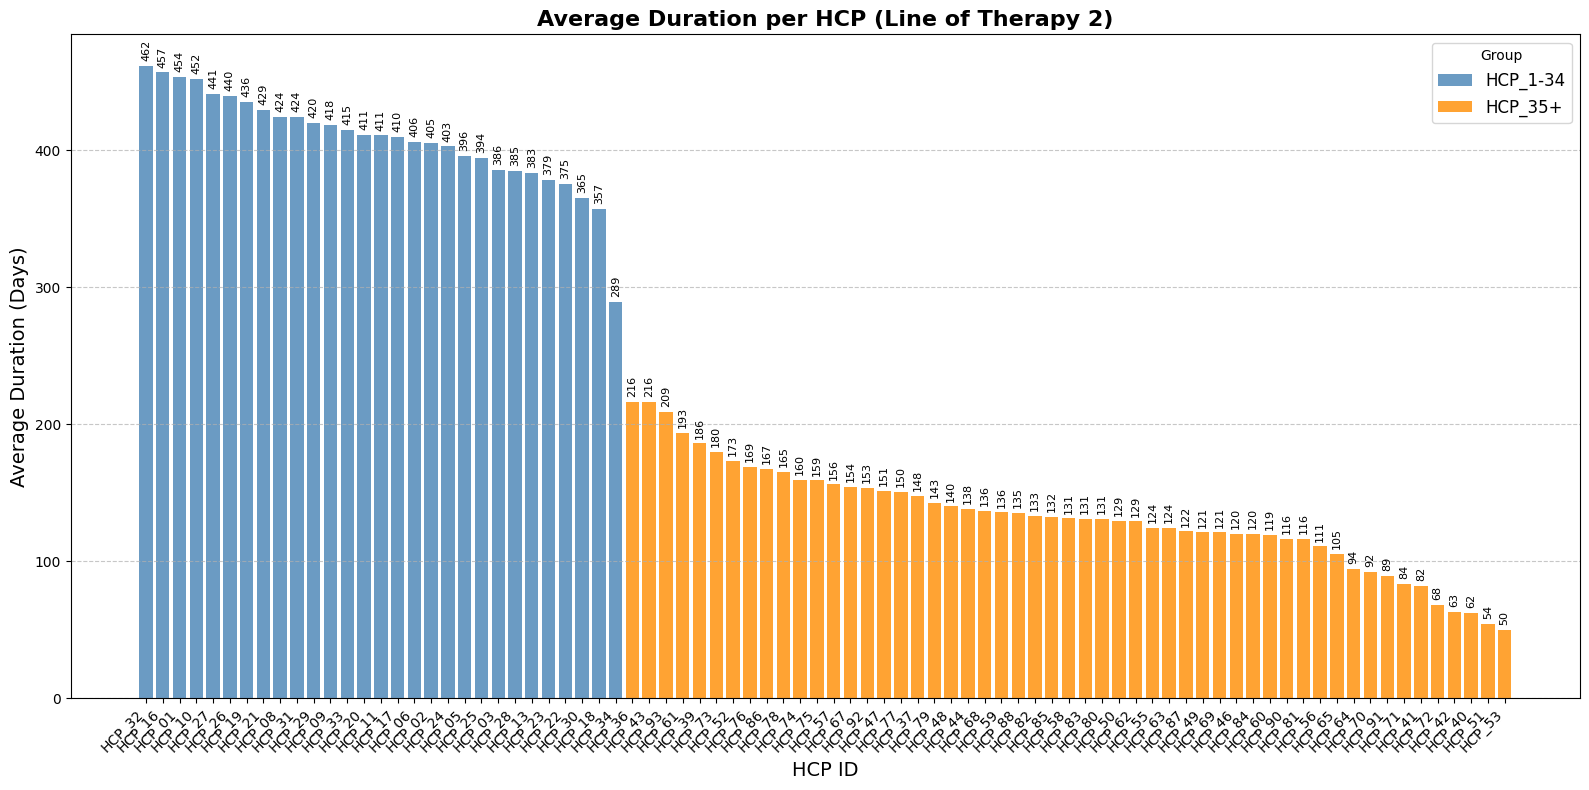

In [ ]:
# Sort data by Group and Duration for better readability
hcp_data_filtered = hcp_data_filtered.sort_values(by=['Group', 'Duration'], ascending=[True, False])

# Plotting with enhanced readability
plt.figure(figsize=(16, 8))
colors = {'HCP_1-34': 'steelblue', 'HCP_35+': 'darkorange'}

for group in hcp_data_filtered['Group'].unique():
    subset = hcp_data_filtered[hcp_data_filtered['Group'] == group]
    plt.bar(subset['HCP_ID'], subset['Duration'], label=group, color=colors[group], alpha=0.8)

# Adding annotations for clarity
for idx, row in hcp_data_filtered.iterrows():
    plt.text(row['HCP_ID'], row['Duration'] + 5, f"{row['Duration']:.0f}", ha='center', fontsize=8, rotation=90)

# Enhanced chart labels and styles
plt.title('Average Duration per HCP (Line of Therapy 2)', fontsize=16, weight='bold')
plt.xlabel('HCP ID', fontsize=14)
plt.ylabel('Average Duration (Days)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Group', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
data_imputation_df[data_imputation_df['HCP_ID']=='HCP_91']

,Pat_ID,HCP_ID,Claim ID,HCPCS_ code,Transaction date,Diagnosis 1,Diagnosis 2,Diagnosis 3,Diagnosis 4,Product Name,...,Product Category,Product Abbreviation,flag,YM,Gap,Lot number,start_date,end_date,Regimen,Year
2236,PATIENT_159,HCP_91,276,70552,2022-05-11,I10,C78.8,S322XXB,NaN,NaN,...,NaN,NaN,2,202205,34.000000,1,2022-04-07,2022-10-14,NOV,2022
2237,PATIENT_159,HCP_91,280,70552,2022-07-10,C34.2,NaN,NaN,NaN,NaN,...,NaN,NaN,2,202207,60.000000,1,2022-04-07,2022-10-14,NOV,2022
2238,PATIENT_159,HCP_91,281,J1002,2022-08-06,C34.12,I10,NaN,NaN,NOVmatinib,...,Market Basket,NOV,2,202208,27.000000,1,2022-04-07,2022-10-14,NOV,2022
2239,PATIENT_159,HCP_91,282,70460,2022-08-18,C34.12,C78,S61111A,NaN,NaN,...,NaN,NaN,3,202208,12.000000,1,2022-04-07,2022-10-14,NOV,2022
2240,PATIENT_159,HCP_91,278,70460,2022-09-09,C34.11,NaN,38524,NaN,NaN,...,NaN,NaN,3,202209,22.000000,1,2022-04-07,2022-10-14,NOV,2022
2241,PATIENT_159,HCP_91,270,70460,2022-10-14,C34.1,75489,NaN,NaN,NaN,...,NaN,NaN,3,202210,35.000000,1,2022-04-07,2022-10-14,NOV,2022
2856,PATIENT_332,HCP_91,1687,J2002,2022-06-11,C34.11,C78.3,NaN,NaN,Paclitaxel,...,Chemotherapy,NaN,2,202206,14.274221,1,2022-06-11,2022-06-11,NaN,2022
2857,PATIENT_332,HCP_91,1686,J2002,2022-09-08,C34.1,C78.7,M25659,NaN,Paclitaxel,...,Chemotherapy,NaN,2,202209,89.000000,2,2022-09-08,2022-09-08,NaN,2022


## **Step 1: Define the Opportunity Score**
We aim to calculate a score that helps identify:
- **Patients likely to stay on the same product (Retention Score)**
- **Patients likely to switch (Switching Score)**

A **higher opportunity score** means a **higher likelihood of switching**, so that interventions (e.g., patient outreach, alternative drug suggestions) can be made in advance.

---

## **Step 2: Key Predictors of Switching**
Using the available features, here’s how we can derive **retention vs. switching likelihood**:

### **1️⃣ Retention Indicators (Higher values = More likely to stay)**
- **Continuous Therapy Duration** (`start_date` to `end_date` for the same product)
- **No Large Gaps Between Claims** (`Gap` feature, lower values suggest continuity)
- **Regimen Stability** (`Regimen` consistency over time)
- **Same HCPCS Code Usage** (Indicates repeated usage of the same procedure or treatment)
- **Patients on L1 or L2 (Base Treatment Level Stability)**

### **2️⃣ Switching Indicators (Higher values = More likely to switch)**
- **Large Gaps Between Claims** (High `Gap` values indicate discontinuity)
- **Multiple Regimens Over Time** (Frequent `Regimen` changes)
- **Frequent Product Name Changes** (`Product Name` change indicates switching)
- **Use of Combination Therapy** (Patients on `L1+Product`, `L2+Product`, `L1+Chemo`, `L2+Chemo` may be transitioning)
- **EGFR Inhibitor Additions** (`L1+EGFR+Product`, `Product+L2+EGFR` may indicate a treatment shift)

---

## **Step 3: Formula for Opportunity Score**
We define:

\[
PSOS = w_1 (\text{Gap}) + w_2 (\text{Regimen Change}) + w_3 (\text{Product Change}) + w_4 (\text{L1/L2 Transition}) + w_5 (\text{Combination Therapy Indicator})
\]

Where:
- **Higher PSOS** → More likely to switch.
- **Lower PSOS** → More likely to stay.

**Example Weights** (Tuned via historical data):
- \( w_1 \) = 0.3 (Gap impact)
- \( w_2 \) = 0.25 (Regimen change impact)
- \( w_3 \) = 0.2 (Product change impact)
- \( w_4 \) = 0.1 (L1/L2 transition)
- \( w_5 \) = 0.05 (Combination therapy involvement)

---

I've computed the **Patient Switching Opportunity Score (PSOS)** for each claim, ranking patients by their likelihood of switching. The **higher the PSOS**, the greater the likelihood of transitioning to a different product or regimen. Let me know if you'd like to adjust weights, incorporate additional features, or apply this to your full dataset! 🚀

In [ ]:
# Convert date columns to datetime format
df["Transaction date"] = pd.to_datetime(df["Transaction date"], format="%m-%d-%Y")
df["start_date"] = pd.to_datetime(df["start_date"], format="%m-%d-%Y")
df["end_date"] = pd.to_datetime(df["end_date"], format="%m-%d-%Y")

# Calculate regimen change indicator (1 if regimen changes, 0 otherwise)
df["Regimen Change"] = df["Regimen"].ne(df["Regimen"].shift()).astype(int)

# Calculate product change indicator (assuming "Product Name" exists)
df["Product Change"] = df["Product Name"].ne(df["Product Name"].shift()).astype(int)

In [ ]:
# Define the target product for switching analysis
target_product = "Ticaprant"

# Adding a column to identify if the patient was on Ticaprant (assuming it appears in "Product Name" or "Regimen")
df["On Ticaprant"] = df["Regimen"].apply(lambda x: 1 if isinstance(x, str) and "TIC" in x else 0)

# Calculate switching indicator:
# A patient is considered a "Switcher" if they move from being on Ticaprant to another product or vice versa
df["Switched from Ticaprant"] = df["On Ticaprant"].shift(1).eq(1) & df["On Ticaprant"].eq(0)
df["Switched to Ticaprant"] = df["On Ticaprant"].shift(1).eq(0) & df["On Ticaprant"].eq(1)

# Overall Switching Indicator (either direction)
df["Switched"] = df["Switched from Ticaprant"] | df["Switched to Ticaprant"]

# Assign weights to features specific to Ticaprant switching
w_gap = 0.3
w_regimen = 0.25
w_product = 0.2
w_tic_switch = 0.4  # Higher weight for actual Ticaprant switch

# Compute **Ticaprant-Specific Patient Switching Opportunity Score (TIC_PSOS)**
df["TIC_PSOS"] = (
    (df["Gap"] * w_gap) +
    (df["Regimen Change"] * w_regimen) +
    (df["Product Change"] * w_product) +
    (df["Switched"].astype(int) * w_tic_switch)
)

# Sort patients by highest Ticaprant-specific opportunity score
df_sorted = df.sort_values(by="TIC_PSOS", ascending=False)

In [ ]:
df_sorted[df_sorted['TIC_PSOS']== 0.00]['Pat_ID'].nunique()

16

In [ ]:
data_imputation_df

,Pat_ID,HCP_ID,Claim ID,HCPCS_ code,Transaction date,Diagnosis 1,Diagnosis 2,Diagnosis 3,Diagnosis 4,Product Name,...,Product Category,Product Abbreviation,flag,YM,Gap,Lot number,start_date,end_date,Regimen,Year
1,PATIENT_001,HCP_17,268985,G9418,2021-06-16,I10,NaN,NaN,NaN,NaN,...,NaN,NaN,2,202106,56.0,1,2021-04-21,2021-06-16,NaN,2021
2,PATIENT_001,HCP_17,277492,J9999,2021-09-08,I10,NaN,NaN,NaN,NaN,...,NaN,NaN,4,202109,84.0,2,2021-09-08,2022-11-22,RIZ_TIC,2021
3,PATIENT_001,HCP_17,286233,J9999,2021-10-06,I10,NaN,NaN,NaN,NaN,...,NaN,NaN,4,202110,28.0,2,2021-09-08,2022-11-22,RIZ_TIC,2021
4,PATIENT_001,HCP_17,302457,J9999,2021-11-03,I10,NaN,NaN,NaN,NaN,...,NaN,NaN,4,202111,28.0,2,2021-09-08,2022-11-22,RIZ_TIC,2021
5,PATIENT_001,HCP_17,321598,G9418,2021-12-01,I10,NaN,NaN,NaN,NaN,...,NaN,NaN,2,202112,28.0,2,2021-09-08,2022-11-22,RIZ_TIC,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,PATIENT_422,HCP_78,2453,78815,2022-05-18,C34.3,75489,E914,NaN,NaN,...,NaN,NaN,2,202205,37.0,1,2022-04-11,2022-06-19,NaN,2022
3216,PATIENT_422,HCP_78,2444,78815,2022-06-19,C34.11,NaN,NaN,NaN,NaN,...,NaN,NaN,2,202206,32.0,1,2022-04-11,2022-06-19,NaN,2022
3217,PATIENT_422,HCP_78,2450,J9999,2022-12-04,C34.8,C78.5,NaN,NaN,NaN,...,NaN,NaN,2,202212,168.0,2,2022-12-04,2022-12-04,NaN,2022
3219,PATIENT_423,HCP_39,2462,70551,2022-04-24,I10,NaN,1794,NaN,NaN,...,NaN,NaN,3,202204,95.0,2,2022-04-24,2022-10-22,NaN,2022


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, fbeta_score

# Define Features
features = ["Gap", "Regimen Change", "Product Change", "On Ticaprant"]
target = "Switched"

# Drop Missing Values
ml_data = df_sorted.dropna(subset=features + [target])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(ml_data[features], ml_data[target], test_size=0.2, random_state=42)

# Train XGBoost with better tuning
xgb_model = XGBClassifier(
    n_estimators=200,
    scale_pos_weight=5,  # Reduced to lower false positives
    max_depth=6,
    learning_rate=0.08,
    min_child_weight=5,  # Avoid overfitting
    gamma=2,  # Penalize complexity
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict probabilities
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Find best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
valid_indices = np.where((precision[:-1] >= 0.5) & (recall[:-1] >= 0.5))[0]
best_threshold = thresholds[valid_indices[0]] if len(valid_indices) > 0 else 0.5

# Increase threshold slightly to reduce false positives
y_pred_adjusted = (y_probs >= best_threshold + 0.05).astype(int)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred_adjusted)
classification_rep = classification_report(y_test, y_pred_adjusted)
f2_score = fbeta_score(y_test, y_pred_adjusted, beta=2)

# Display results
print(f"Model Accuracy: {accuracy}")
print(f"F2-score: {f2_score}")
print("Classification Report:")
print(classification_rep)


Model Accuracy: 0.9842022116903634
F2-score: 0.5294117647058824
Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       614
        True       1.00      0.47      0.64        19

    accuracy                           0.98       633
   macro avg       0.99      0.74      0.82       633
weighted avg       0.98      0.98      0.98       633



In [ ]:
# Display sorted patient scores
df_sorted[["Pat_ID", "TIC_PSOS"]].head(10)

,Pat_ID,TIC_PSOS
2488,PATIENT_233,80.95
2633,PATIENT_273,76.95
3003,PATIENT_366,71.55
3035,PATIENT_373,69.60
2691,PATIENT_290,67.65
2961,PATIENT_357,67.50
3129,PATIENT_399,67.05
2361,PATIENT_190,62.85
3091,PATIENT_391,59.35
2462,PATIENT_224,58.35


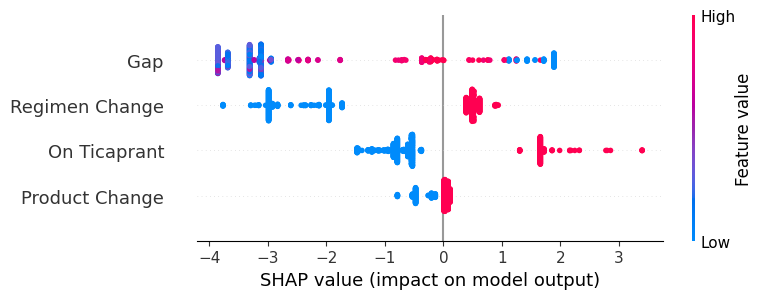

In [ ]:
# SHAP Analysis
# SHAP Analysis
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)







In [ ]:
import pandas as pd

# Get false positives and false negatives
false_positives = X_test[(y_pred_adjusted == 1) & (y_test == 0)]
false_negatives = X_test[(y_pred_adjusted == 0) & (y_test == 1)]

# Count occurrences
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

# Show sample errors
false_negatives.head()


False Positives: 0
False Negatives: 10


,Gap,Regimen Change,Product Change,On Ticaprant
247,0.0,1,1,0
222,0.0,1,1,0
797,0.0,1,1,0
2729,0.0,1,1,0
917,0.0,1,1,0


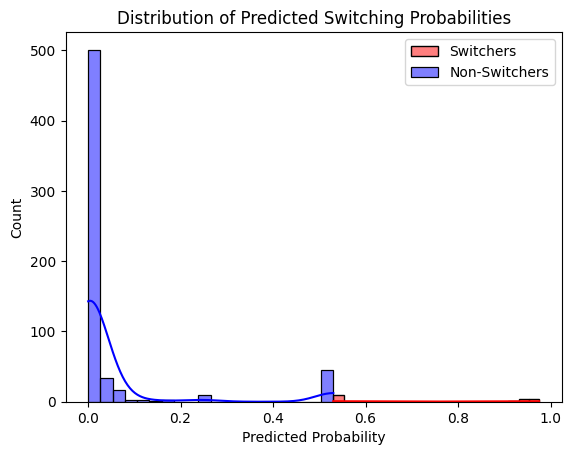

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted probabilities
sns.histplot(y_probs[y_test == 1], bins=20, color="red", label="Switchers", kde=True)
sns.histplot(y_probs[y_test == 0], bins=20, color="blue", label="Non-Switchers", kde=True)
plt.legend()
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Distribution of Predicted Switching Probabilities")
plt.show()


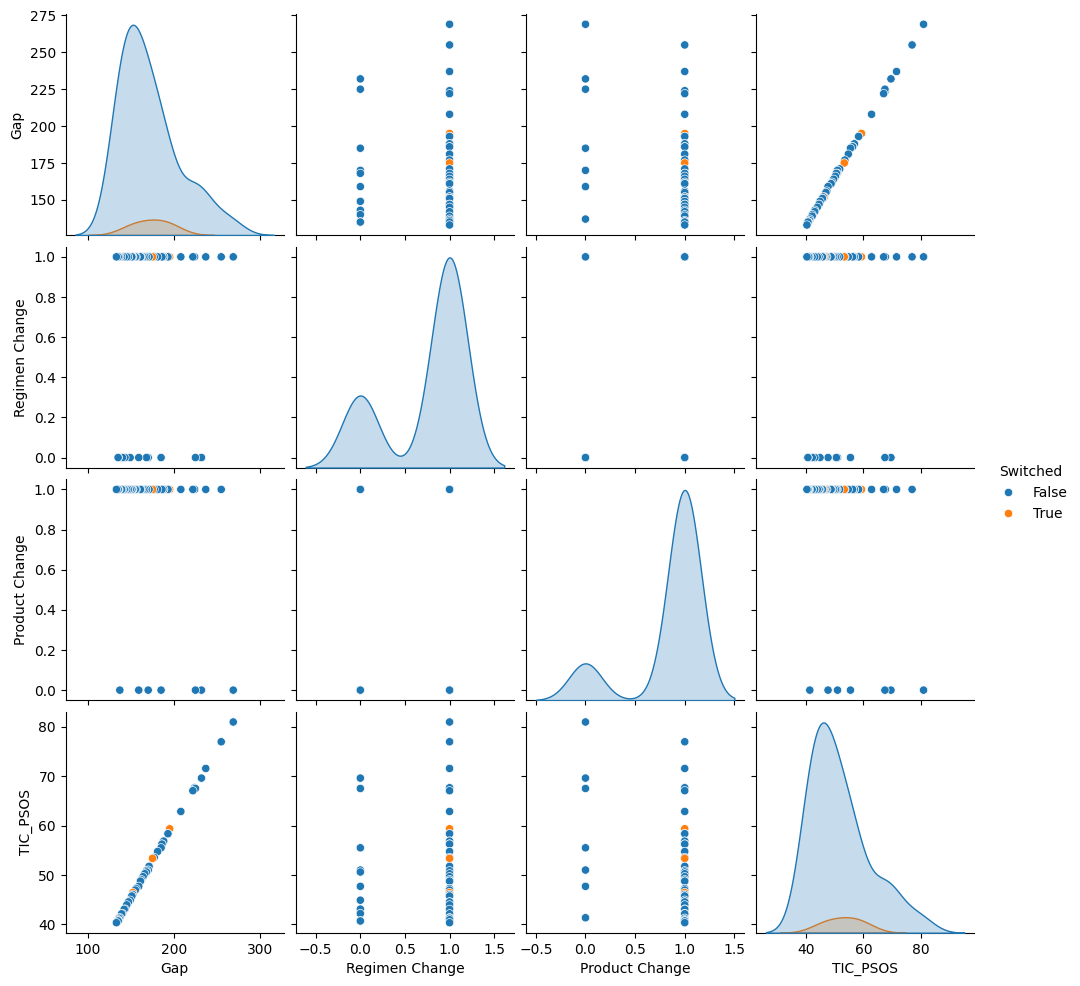

In [ ]:
import seaborn as sns

# Sort by highest TIC_PSOS
top_switchers = df_sorted.sort_values("TIC_PSOS", ascending=False).head(50)

# Pairplot to visualize key differences
sns.pairplot(top_switchers, vars=["Gap", "Regimen Change", "Product Change", "TIC_PSOS"], hue="Switched")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select relevant features from df_sorted (Adjust these columns based on what exists in your notebook)
features = ['switch_rate', 'avg_treatment_duration', 'drug_variety', 'total_patients']
X = df_sorted[features].copy()

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal clusters using Elbow Method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# Choose optimal k based on the elbow curve
optimal_k = 4  # Adjust this after checking the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_sorted["cluster"] = kmeans.fit_predict(X_scaled)

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_sorted["pca1"] = X_pca[:, 0]
df_sorted["pca2"] = X_pca[:, 1]

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x="pca1", y="pca2", hue="cluster", data=df_sorted, palette="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("HCP Clustering Based on Prescribing Patterns")
plt.legend(title="Cluster")
plt.show()

# Show cluster statistics
cluster_summary = df_sorted.groupby("cluster")[features].mean()
import ace_tools as tools
tools.display_dataframe_to_user(name="HCP Cluster Summary", dataframe=cluster_summary)


KeyError: "None of [Index(['switch_rate', 'avg_treatment_duration', 'drug_variety',\n       'total_patients'],\n      dtype='object')] are in the [columns]"